In [20]:
import torch
import HodgkinHuxley
import matplotlib.pyplot as plt
import numpy as np
import functions as func
import time
import sys

In [21]:

sys.path.append(
    '/home/samuel/Documents/projects/seq posterior approx w nf/seq posterior approx w nf dev/algorithms')

import spa as spa


In [22]:
import sys
print("Python version")
print (sys.version)

print("Version info.")
print (sys.version_info)

Python version
3.7.4 (default, Aug 13 2019, 20:35:49) 
[GCC 7.3.0]
Version info.
sys.version_info(major=3, minor=7, micro=4, releaselevel='final', serial=0)


In [23]:
import os

print(os.getcwd())

seed_data = 7

/home/samuel/Documents/projects/seq posterior approx w nf/seq posterior approx w nf dev/hodgkin_huxley


## Gen sbi data

In [24]:
model = HodgkinHuxley.HodgkinHuxley("snl")

In [25]:
t_vec = np.array(HodgkinHuxley.h.t_vec)

In [26]:
v_true, Iinj = model.simulator(model.log_theta_true, seed_data, True)


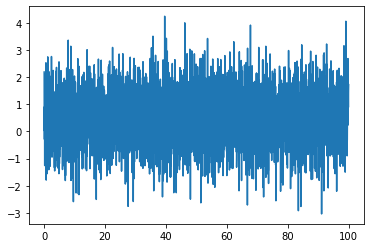

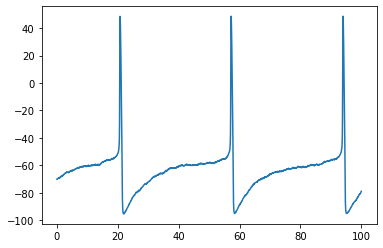

In [27]:

plt.figure()
plt.plot(t_vec, Iinj)

plt.figure()
plt.plot(t_vec, v_true)


In [28]:
summary_stats_obs = model.calculate_summary_statistics(v_true)


In [29]:
summary_stats_obs

array([-6.40828856e+01,  2.81086579e+00,  2.79212967e+00,  1.17168804e+02,
        4.67103817e+03,  3.00037889e+00,  6.60806063e+00,  1.03037433e+01,
        3.99239771e+03,  3.80963892e+03,  3.75168188e+03,  3.66387183e+03,
        3.57566284e+03,  3.48756299e+03,  3.40273657e+03,  3.32262183e+03,
        3.25609912e+03,  3.11782129e+03])

#### set up model simulator

In [30]:
def simulator_wrapper(params):

    # return tensor
    return model.calculate_summary_statistics(model.simulator(params))


In [31]:
# run pilot to calc mean and std of summary stats
whiteness_params = func.pilot_run(model, simulator_wrapper, summary_stats_obs)


Pilot run: running 2000 simulations: 100%|██████████| 2000/2000 [00:29<00:00, 67.00it/s]


In [32]:
summary_stats_obs_w = func.whiten(summary_stats_obs, whiteness_params)


In [33]:
#m_prior, std_prior = func.load_summary_stats_mean_and_std()


In [34]:
#w_sim_wrapper = lambda param: torch.as_tensor(func.whiten(simulator_wrapper(param), whiteness_params))


def simulator(params):

    N = params.shape[0]
    data = torch.zeros(params.shape[0],18)

    for i in range(N):
        data[i, :] = torch.as_tensor(func.whiten(simulator_wrapper(params[i,:]), whiteness_params))

    return data



In [35]:
flow_lik, flow_post = func.set_up_networks(model.prior.base_dist.low,
                                               model.prior.base_dist.high)

optimizer_lik = torch.optim.Adam(flow_lik.parameters())
optimizer_post = torch.optim.Adam(flow_post.parameters(), lr=0.001)  # used def value before
decay_rate_post = 0.9  # no adaptation of Adam's base rate

tensor([-2.5702, -1.7965,  1.6719, -1.7965, -2.1833, -1.9843,  1.8710, -3.4684,
        -1.8982,  0.3869])
tensor([0.5581, 0.5581, 0.5581, 0.5581, 0.5581, 0.5581, 0.5581, 0.5581, 0.5581,
        0.5581])


In [36]:
s_x_o = torch.from_numpy(summary_stats_obs_w).to(dtype=torch.float32).reshape(1,18)

nbr_rounds = 5
prob_prior_decay_rate = 0.9
prob_prior = spa.calc_prob_prior(nbr_rounds, prob_prior_decay_rate)

print(prob_prior)

[1.0, 0.4065696597405991, 0.16529888822158653, 0.06720551273974976, 0.02732372244729256]


In [37]:
nbr_lik = [1000, 1000, 1000, 1000, 1000]  # , 2000, 2000]
nbr_epochs_lik = [50, 50, 50, 50, 50]
batch_size = 50
batch_size_post = 50
nbr_post = [10000, 10000, 10000, 10000, 10000]  # , 10000, 10000]
nbr_epochs_post = [25, 25, 25, 25, 25, 25]

x_o_batch_post = torch.zeros(batch_size_post, 18)

for i in range(batch_size_post):
    x_o_batch_post[i, :] = s_x_o

In [38]:
torch.manual_seed(1)
np.random.seed(1)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

dim_post = 10
start = time.time()

models_lik, models_post = spa.inference_spa(flow_lik,
                                            flow_post,
                                            model.prior,
                                            simulator,
                                            optimizer_lik,
                                            optimizer_post,
                                            decay_rate_post,
                                            s_x_o,
                                            x_o_batch_post,
                                            dim_post,
                                            prob_prior,
                                            nbr_lik,
                                            nbr_epochs_lik,
                                            nbr_post,
                                            nbr_epochs_post,
                                            batch_size,
                                            batch_size_post)

end = time.time()
run_time = end - start


start full training
Iteration: 1
optimizer_post_lr: [0.001]
prob_prior: 1.0
start update likelihood model
Epoch: 0, loss (training): 81.7417, loss (eval): 123.0402
Epoch: 1, loss (training): 50.2432, loss (eval): 59.4638
Epoch: 2, loss (training): 36.5294, loss (eval): 39.8377
Epoch: 3, loss (training): 31.1108, loss (eval): 31.3368
Epoch: 4, loss (training): 28.0637, loss (eval): 27.386
Epoch: 5, loss (training): 26.682, loss (eval): 25.5642
Epoch: 6, loss (training): 25.8181, loss (eval): 24.7878
Epoch: 7, loss (training): 25.2107, loss (eval): 24.1891
Epoch: 8, loss (training): 24.6143, loss (eval): 23.5857
Epoch: 9, loss (training): 24.1001, loss (eval): 23.017
Epoch: 10, loss (training): 23.492, loss (eval): 22.5313
Epoch: 11, loss (training): 22.9491, loss (eval): 21.9504
Epoch: 12, loss (training): 22.4105, loss (eval): 21.4545
Epoch: 13, loss (training): 21.7699, loss (eval): 21.0251
Epoch: 14, loss (training): 21.1016, loss (eval): 20.3796
Epoch: 15, loss (training): 20.4649, 

In [40]:
start = time.time()

for i in range(nbr_rounds):
    posterior_sample = models_post[i].sample(1000, context=s_x_o)
    posterior_sample = posterior_sample.reshape((1000, 10))
    np.savetxt('data/post_samples_snpla_' + str(i + 1) + '_' + '.csv',
               posterior_sample.detach().numpy(), delimiter=",")

end = time.time()
run_time_inference = (end - start) / nbr_rounds

# Write results

with open('results/snpla_' + '.txt', 'w') as f:
    f.write('%.4f\n' % run_time)
    f.write('%.4f\n' % run_time_inference)

In [ ]:
a = 1
b = 2

flow_post = build_custom_post_net(a,b)



In [ ]:
s_temp = flow_post.sample(10)

In [ ]:
s_temp


In [ ]:
s = torch.from_numpy(summary_stats_obs_w).to(dtype=torch.float32).reshape(1,18)
s_temp = flow_post.sample(10, context=s)


# why is this samping the same values???


In [ ]:
s_temp

In [ ]:
print(summary_stats_obs)

print(summary_stats_obs_w)

In [ ]:
inference = SNPE_C(simulator, prior, density_estimator=build_custom_post_net)

In [ ]:
start = time.time()

torch.manual_seed(1)
np.random.seed(1)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

import math

num_rounds = 5
x_o = torch.from_numpy(summary_stats_obs_w).to(dtype=torch.float32).reshape(1,18)

posteriors = []
proposal = None

for i in range(num_rounds):
    #lr = 0.001*math.exp(-0.95 * i)
    posterior = inference(num_simulations=2000, proposal=proposal, max_num_epochs=100) #, learning_rate=lr)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(x_o)


end = time.time()
run_time = end - start

print("")
print("Runtime:" + str(round(run_time, 2)))

In [ ]:
samples1 = posteriors[0].sample((2000,), x=x_o)
samples2 = posteriors[1].sample((2000,), x=x_o)
samples3 = posteriors[2].sample((2000,), x=x_o)
samples4 = posteriors[3].sample((2000,), x=x_o)
samples5 = posteriors[4].sample((2000,), x=x_o)

In [ ]:
prior_limits = []

for i in range(10):
    prior_limits.append([round(model.prior.base_dist.low[i].item(),1),
                         round(model.prior.base_dist.high[i].item(),1)])


In [ ]:
labels = ["log(gbar_Na)",
          "log(gbar_K)",
          "log(g_leak)",
          "log(E_Na)",
          "log(-E_K)",
          "log(-E_leak)",
          "log(gbar_M)",
          "log(tau_max)",
          "log(Vt)",
           "log(sigma)"]

In [ ]:
from sbi import utils as utils
fig, axes = utils.pairplot(samples1,
                           points=torch.as_tensor(model.log_theta_true),
                           points_offdiag={'markersize': 6},
                           points_colors='r',
                           limits=prior_limits,
                           ticks=prior_limits,
                           labels = labels)

In [ ]:
from sbi import utils as utils
fig, axes = utils.pairplot(samples2,
                           points=torch.as_tensor(model.log_theta_true),
                           points_offdiag={'markersize': 6},
                           points_colors='r',
                           limits=prior_limits,
                           ticks=prior_limits,
                           labels = labels)


In [ ]:
from sbi import utils as utils
fig, axes = utils.pairplot(samples3,
                           points=torch.as_tensor(model.log_theta_true),
                           points_offdiag={'markersize': 6},
                           points_colors='r',
                           limits=prior_limits,
                           ticks=prior_limits,
                           labels = labels)

In [ ]:
from sbi import utils as utils
fig, axes = utils.pairplot(samples4,
                           points=torch.as_tensor(model.log_theta_true),
                           points_offdiag={'markersize': 6},
                           points_colors='r',
                           limits=prior_limits,
                           ticks=prior_limits,
                           labels = labels)

In [ ]:
from sbi import utils as utils
fig, axes = utils.pairplot(samples5,
                           points=torch.as_tensor(model.log_theta_true),
                           points_offdiag={'markersize': 6},
                           points_colors='r',
                           limits=prior_limits,
                           ticks=prior_limits,
                           labels = labels)
